### Test Corr Models

In [18]:
import numpy as np
import pandas as pd
from copy import deepcopy
import yfinance as yf

import dynamic_correlations as CM
import expected_shortfall as ES
import backtesting as BT
import plots as IP
import data_download as dd

### Data 

In [21]:
# Step 1: Define tickers and shares
tickers = [
    "AAPL", "MSFT", "NVDA", "GOOGL", "JPM",
    "UNH", "KO", "PEP", "BMW.DE", "NESN.SW",
    "NOVN.SW", "ASML.AS"
]

# Assign number of shares per asset
shares = pd.Series(10, index=tickers)

# Step 2: Download adjusted prices
prices = dd.get_raw_prices(tickers, start="2018-01-01")

# Step 3: Compute monetary positions
x_matrix = prices * shares

# Step 4: Convert positions to CHF
x_matrix = dd.convert_to_base(x_matrix, base="CHF")

# Step 5: Compute returns and summary stats
returns, mean_returns, covariance_matrix = dd.compute_returns_stats(x_matrix)

# Step 6: Display results
print(f"\nPortfolio final value in CHF: {x_matrix.sum(axis=1).iloc[-1]:.2f}")
print("\nSample of daily returns:\n", returns.head())
print("\nMean returns (daily, in CHF):\n", mean_returns)
print("\nCovariance matrix (in CHF):\n", covariance_matrix)


[currency detection] AAPL: USD
[currency detection] ASML.AS: EUR
[currency detection] BMW.DE: EUR
[currency detection] GOOGL: USD
[currency detection] JPM: USD
[currency detection] KO: USD
[currency detection] MSFT: USD
[currency detection] NESN.SW: CHF
[currency detection] NOVN.SW: CHF
[currency detection] NVDA: USD
[currency detection] PEP: USD
[currency detection] UNH: USD
[fx download] Downloading FX pairs: CHFUSD=X, CHFEUR=X
[conversion] AAPL: USD → CHF via CHFUSD=X
[conversion] ASML.AS: EUR → CHF via CHFEUR=X
[conversion] BMW.DE: EUR → CHF via CHFEUR=X
[conversion] GOOGL: USD → CHF via CHFUSD=X
[conversion] JPM: USD → CHF via CHFUSD=X
[conversion] KO: USD → CHF via CHFUSD=X
[conversion] MSFT: USD → CHF via CHFUSD=X
[conversion] NVDA: USD → CHF via CHFUSD=X
[conversion] PEP: USD → CHF via CHFUSD=X
[conversion] UNH: USD → CHF via CHFUSD=X

Portfolio final value in CHF: 22879.48

Sample of daily returns:
                 AAPL   ASML.AS    BMW.DE     GOOGL       JPM        KO  \
Date

In [22]:
x_matrix.head()

,AAPL,ASML.AS,BMW.DE,GOOGL,JPM,KO,MSFT,NESN.SW,NOVN.SW,NVDA,PEP,UNH
Date,,,,,,,,,,,,
2018-01-02,394.565054,1587.152288,670.839610,520.550879,853.580449,353.552516,774.650602,NaN,NaN,48.048117,928.636685,1935.163220
2018-01-03,393.177010,1612.540933,675.027853,527.661271,851.592633,351.596313,775.652634,666.336975,508.271980,51.039071,923.100169,1948.922857
2018-01-04,397.312720,1632.752579,680.787710,532.808105,868.842662,358.633044,787.054677,665.697556,505.593719,51.608122,933.071098,1968.826732
2018-01-05,400.709555,1658.047089,690.183684,538.359380,860.844258,357.549806,794.578120,669.213791,511.802559,51.899507,933.127989,2000.743417
2018-01-08,399.491583,1675.561133,697.961866,540.626111,862.699728,357.248294,795.927846,668.414688,510.950279,53.525971,928.409676,1967.348718


In [23]:
# Run MA Correlation VaR
x_ma = deepcopy(x_matrix)
result_ma= CM.var_corr_moving_average(x_ma, window_size=20)

# Run RiskMetrics Correlation VaR
x_rm = deepcopy(x_matrix)
result_rm = CM.var_corr_ewma(x_rm)


In [24]:
result_ma.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation
2018-01-31,0.000034,0.008458,0.019675,187.798515,False
2018-02-01,-0.006207,0.008324,0.019366,183.689353,False
2018-02-02,-0.023906,0.009720,0.022613,209.334611,True
2018-02-05,-0.027333,0.011361,0.026430,237.912222,True
2018-02-06,0.001949,0.011374,0.026460,238.457879,False


In [25]:
result_rm.head()

,Returns,Volatility,VaR,VaR Monetary,VaR Violation
2018-01-04,0.010600,0.011704,0.027228,255.483952,False
2018-01-05,0.009025,0.011568,0.026912,254.776475,False
2018-01-08,-0.000842,0.011220,0.026102,246.879063,False
2018-01-09,0.003592,0.010904,0.025367,240.777216,False
2018-01-10,-0.002539,0.010596,0.024651,233.362421,False


In [26]:
# Apply volatility-based ES to the MA VaR result
result_ma = ES.es_correlation(result_ma, confidence_level=0.99)

# Same for RiskMetrics
result_rm = ES.es_correlation(result_rm, confidence_level=0.99)


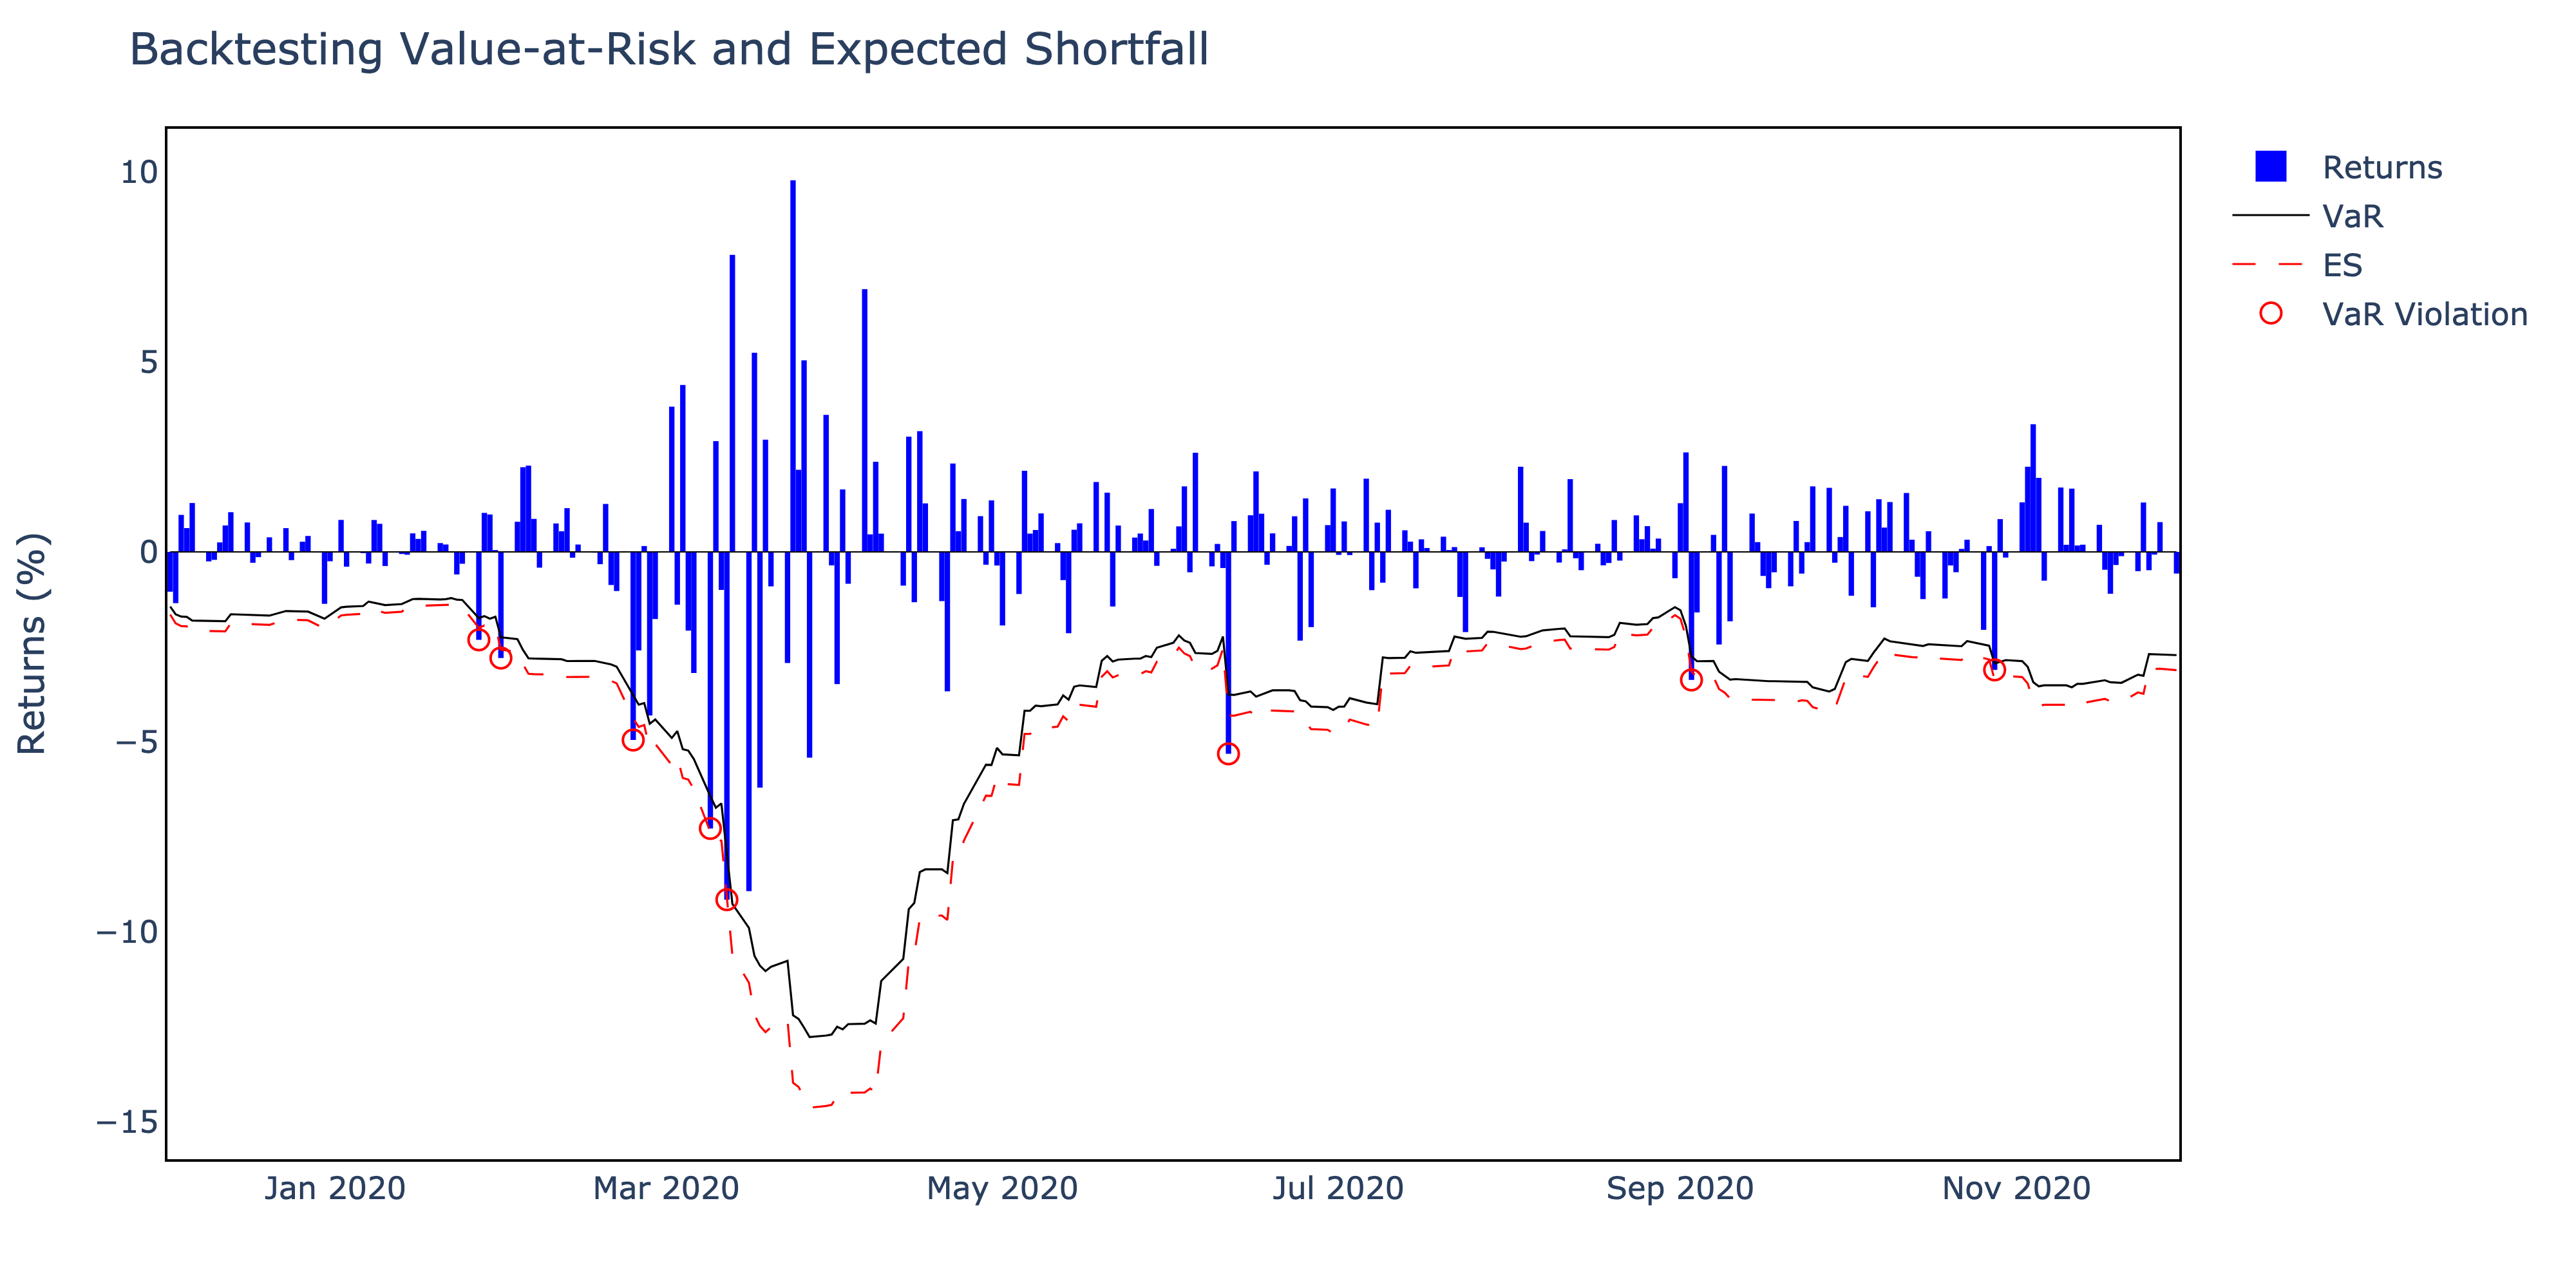


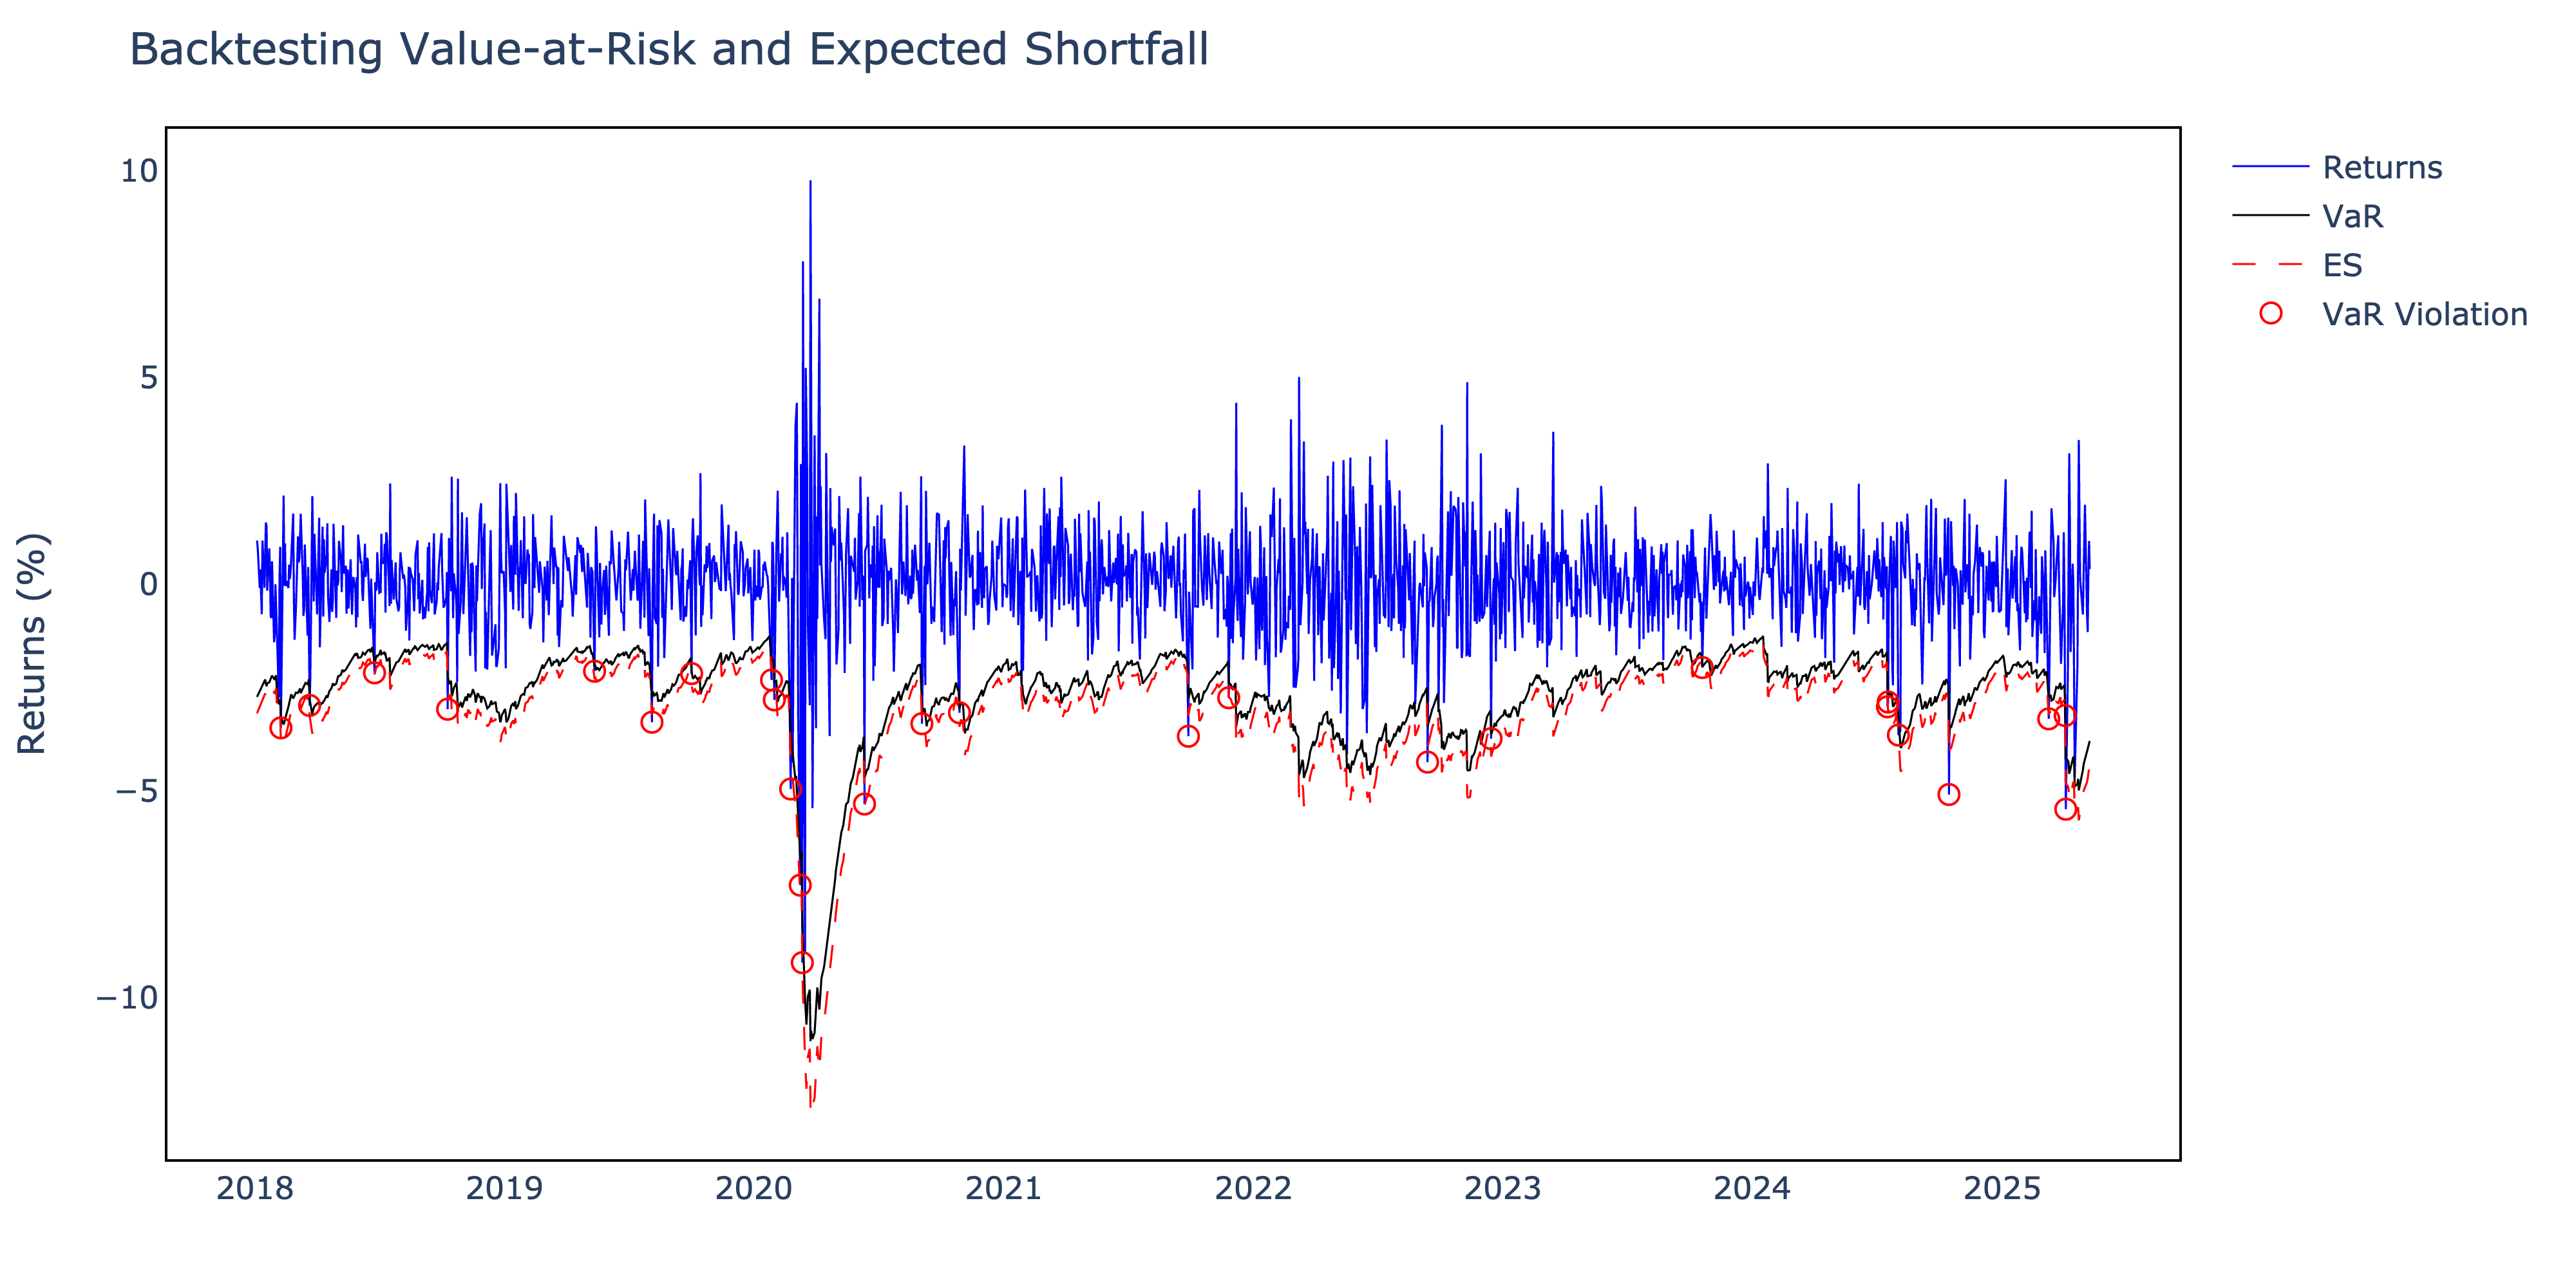

In [27]:
# Plot MA model results
fig_ma_es = IP.plot_backtest(result_ma, subset=("2019-11-30", "2020-11-30"), interactive=False)

# Plot RiskMetrics model results
fig_rm_es = IP.plot_backtest(result_rm, interactive=False)


In [28]:
violations_ma, rate_ma = BT.count_violations(result_ma)

print("== MA Correlation VaR Backtest ==")
print(f"Total Violations: {violations_ma}")
print(f"Violation Rate: {rate_ma:.2f}%")

== MA Correlation VaR Backtest ==
Total Violations: 32
Violation Rate: 1.70%


In [29]:
violations_rm, rate_rm = BT.count_violations(result_rm)

print("== RiskMetrics Correlation VaR Backtest ==")
print(f"Total Violations: {violations_rm}")
print(f"Violation Rate: {rate_rm:.2f}%")

== RiskMetrics Correlation VaR Backtest ==
Total Violations: 27
Violation Rate: 1.42%


In [30]:
fig_ma_vol = IP.plot_volatility(result_ma["Volatility"])
fig_rm_vol = IP.plot_volatility(result_rm["Volatility"])

### Bakctesting 

In [31]:
# 1. Recompute monetary positions (already done)
x_rm = deepcopy(x_matrix)

# 2. Run RiskMetrics Correlation VaR
result_rm = CM.var_corr_ewma(x_rm)

# 3. Count violations
total_violations, violation_rate = BT.count_violations(result_rm)

# 4. Run Kupiec test
confidence_level = 0.99  # adjust if needed
kupiec_results = BT.kupiec_test(total_violations, len(result_rm), confidence_level)

# 5. Run Christoffersen test
christoffersen_results = BT.christoffersen_test(result_rm)

# 6. Joint test
joint_results = BT.joint_lr_test(
    LR_uc=kupiec_results["LR_uc"],
    LR_c=christoffersen_results["LR_c"]
)


In [32]:
print("=== VaR Backtesting Summary ===")
print(f"Total Violations: {total_violations}")
print(f"Violation Rate: {violation_rate:.2f}%")

print("\n-- Kupiec Test --")
for k, v in kupiec_results.items():
    print(f"{k}: {v}")

print("\n-- Christoffersen Test --")
for k, v in christoffersen_results.items():
    print(f"{k}: {v}")

print("\n-- Joint Test --")
for k, v in joint_results.items():
    print(f"{k}: {v}")


=== VaR Backtesting Summary ===
Total Violations: 27
Violation Rate: 1.42%

-- Kupiec Test --
LR_uc: 3.0266375601976847
p_value: 0.08190759582299689
reject_null: False

-- Christoffersen Test --
LR_c: 3.56826533764189
p_value: 0.058893802929611105
reject_null: False

-- Joint Test --
LR_total: 6.5949028978395745
p_value: 0.036977285919345126
reject_null: True


In [33]:
# 1. Recompute monetary positions (already done)
x_rm = deepcopy(x_matrix)

# 2. Run RiskMetrics Correlation VaR
result_rm = CM.var_corr_ewma(x_rm)

# 3. Count violations
total_violations, violation_rate = BT.count_violations(result_ma)

# 4. Run Kupiec test
confidence_level = 0.99  # adjust if needed
kupiec_results = BT.kupiec_test(total_violations, len(result_ma), confidence_level)

# 5. Run Christoffersen test
christoffersen_results = BT.christoffersen_test(result_ma)

# 6. Joint test
joint_results = BT.joint_lr_test(
    LR_uc=kupiec_results["LR_uc"],
    LR_c=christoffersen_results["LR_c"]
)


In [34]:
print("=== VaR Backtesting Summary ===")
print(f"Total Violations: {total_violations}")
print(f"Violation Rate: {violation_rate:.2f}%")

print("\n-- Kupiec Test --")
for k, v in kupiec_results.items():
    print(f"{k}: {v}")

print("\n-- Christoffersen Test --")
for k, v in christoffersen_results.items():
    print(f"{k}: {v}")

print("\n-- Joint Test --")
for k, v in joint_results.items():
    print(f"{k}: {v}")


=== VaR Backtesting Summary ===
Total Violations: 32
Violation Rate: 1.70%

-- Kupiec Test --
LR_uc: 7.748341385444633
p_value: 0.005376189459627256
reject_null: True

-- Christoffersen Test --
LR_c: 5.717972269454265
p_value: 0.01679211244641865
reject_null: True

-- Joint Test --
LR_total: 13.466313654898897
p_value: 0.0011907679695459805
reject_null: True
